Metin Abadan - 19050111015

Sertac İnce - 20050111003

Reading from csv

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("spamData.csv", encoding='latin-1')

Remove unnecessary attributes / columns

In [2]:
df.drop(df.columns[4], axis=1, inplace=True)
df.drop(df.columns[3], axis=1, inplace=True)
df.drop(df.columns[2], axis=1, inplace=True)

Dividing data into x and y

In [3]:
x = list(df['rawText'])
y = list(df['target'])

In order to draw a ROC curve, the target layers must consist of 0 and 1.
So we changed the 'ham' class to '0' and the 'spam' class to '1' in the target layer.

In [4]:
for i in range(len(y)):
  if y[i] == 'ham':
    y[i] = 0
  else:
    y[i] = 1

## Prepare feature vectors from raw text

Raw text has varying size and not regular, so it is not useful as an input data for classification methods which expects feature vectors with fixed dimension and numeric values. In natural language processing (NLP) one way is to build a dictionary where all words are extracted using all the textual data. Then, for each data a feature vector will be constructed that contains frequencies of the words in the dictionary. Note that, number of words can be huge (in this dataset dictionary size is 13496). So, for spam dataset, original data contains 5572 texts then we will construct a suitable data with 5572 rows (n) and 13496 columns/attributes (p).

In [5]:
class tokenizer:
    def __init__(self, text_data):
        self.vocab = {}
        self.__get_vocab(text_data)
        
    def convert_text_dataset_to_matrix(self, X):
        vocab = self.vocab
        result = []       
        for text in tqdm(X):
            vector = self.__text_to_vector(text)
            result.append(vector)
        return result
    
    def __get_vocab(self, text_data):
        word_id = 0
        for text in text_data:
            words = text.split()
            for word in words:
                word = word.lower()
                if word not in self.vocab:
                    self.vocab[word] = word_id
                    word_id += 1
        print(f'Dictionary size : {len(self.vocab)}')
    
    def __text_to_vector(self, text):
        vocab = self.vocab
        result = list(np.zeros(len(vocab)))
        words = text.split()
        for word in words:
            word = word.lower()
            if word in vocab:
                result[vocab[word]] += 1
        return result

In [6]:
from tqdm import tqdm

tz = tokenizer(x)

Dictionary size : 13496


In [7]:
X = tz.convert_text_dataset_to_matrix(x)

100%|██████████| 5572/5572 [00:05<00:00, 1038.35it/s]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

print(f'Training set size is {len(X_train)} rows')
print(f'Test set size is {len(X_test)} rows')
print(f'Train + test set size is {len(X_train) + len(X_test)} rows')

Training set size is 3900 rows
Test set size is 1672 rows
Train + test set size is 5572 rows


# K-Nearest Neighbors Classifier

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [16]:
import time 

knn = KNeighborsClassifier(n_neighbors=1)
start_knn = time.time()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
end_knn = time.time() - start_knn

In [12]:
print(metrics.accuracy_score(y_test, y_pred_knn))

0.9533492822966507


### Confusion Matrix of the KNN

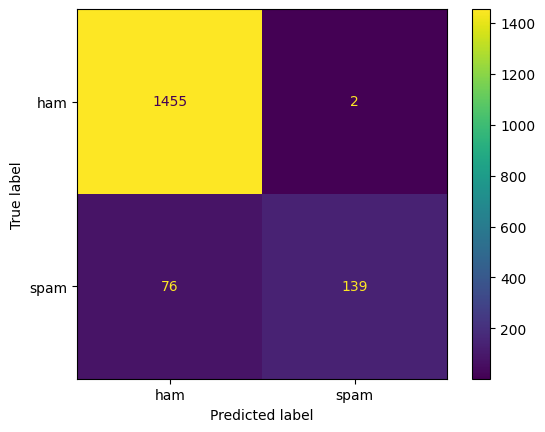

In [14]:
confusion_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display_knn = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_knn, display_labels = ["ham", "spam"])

cm_display_knn.plot()
plt.show()

In this confusion matrix, we can understand that the accuracy (TP/(TP+TN)) rate is very high so model look like fine but we have to examine precision, recall, F1 and again we have to interpret FN and FP values. Interpreting FP and FN values depends on the case. In this case we don't want to get high FP because that means non-spam mails will be disappear. Also, we want a low FN value, but a certain error rate is acceptable for this situation. For this classification FN and FP values looks fine for now. We will discuss and compare other classifier's results in the comparison part.

### Precision, Recall and F-Score/F-measure for the KNN

In [15]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1457
           1       0.99      0.65      0.78       215

    accuracy                           0.95      1672
   macro avg       0.97      0.82      0.88      1672
weighted avg       0.95      0.95      0.95      1672



### ROC Curve of the KNN

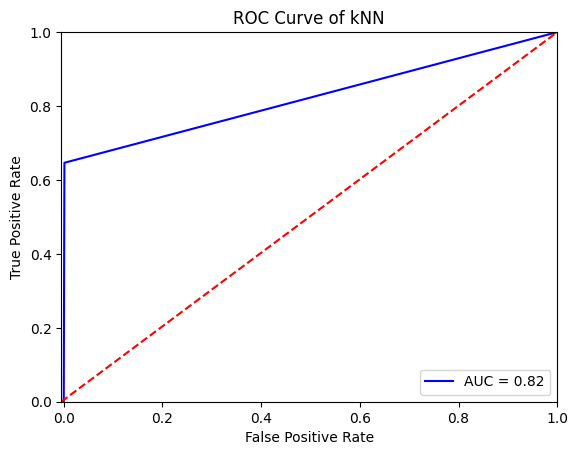

In [16]:
y_scores_knn = knn.predict_proba(X_test)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, y_scores_knn[:, 1])

roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn, tpr_knn, 'b', label = 'AUC = %0.2f' % roc_auc_knn)
plt.legend(loc = 'lower right')
plt.plot([-0.005, 1], [0, 1],'r--')
plt.xlim([-0.005, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

# Support Vector Machine Classifier


we are using linear for kernel because of the text classification

In [17]:
from sklearn.svm import SVC

random_state = np.random.RandomState(0)

start_svm = time.time()
classifier = SVC(kernel = 'linear', random_state = random_state, probability=True, gamma='auto')
classifier.fit(X_train, y_train)
end_svm = time.time() - start_svm

Because of the setting the probability to true, our computation time took too long (upper cell's execution time was 19 minutes)

In [19]:
y_pred_svm = classifier.predict(X_test)

In [19]:
print(metrics.accuracy_score(y_test, y_pred_svm))

0.9826555023923444


### Confusion Matrix of the SVM

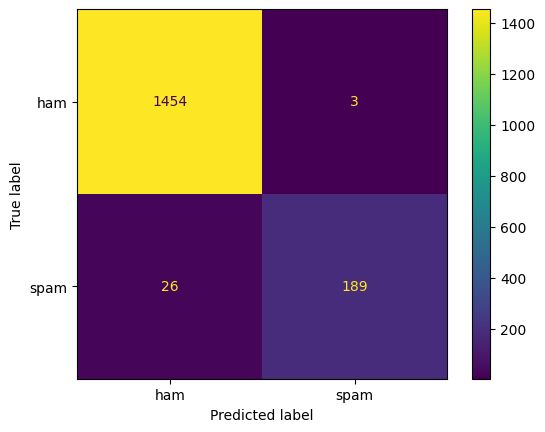

In [20]:
confusion_matrix_svm = metrics.confusion_matrix(y_test, y_pred_svm)
cm_display_svm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svm, display_labels = ["ham", "spam"])

cm_display_svm.plot()
plt.show()

### Precision, Recall and F-Score/F-measure for the SVM

In [21]:
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1457
           1       0.98      0.88      0.93       215

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



### ROC Curve of the SVM

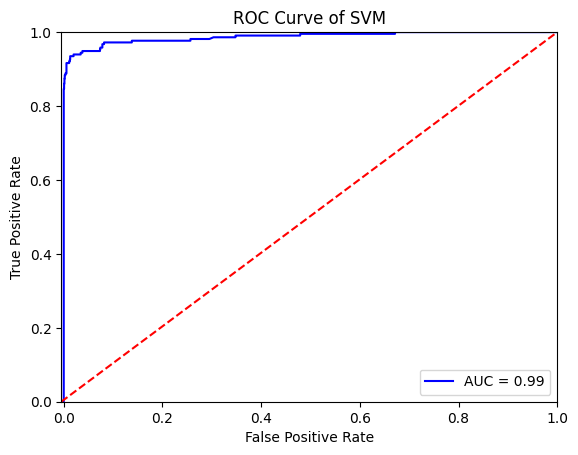

In [23]:
y_scores_svm = classifier.predict_proba(X_test)
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_scores_svm[:, 1])

roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_svm, tpr_svm, 'b', label = 'AUC = %0.2f' % roc_auc_svm)
plt.legend(loc = 'lower right')
plt.plot([-0.005, 1], [0, 1],'r--')
plt.xlim([-0.005, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of SVM')
plt.show()

# Naive Bayes Classifier

In [15]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
start_bayes = time.time()
nb.fit(X_train, y_train)
y_pred_bayes = nb.predict(X_test)
end_bayes = time.time() - start_bayes

In [26]:
print(metrics.accuracy_score(y_test, y_pred_bayes))

0.9324162679425837


### Confusion Matrix of the Naive Bayes

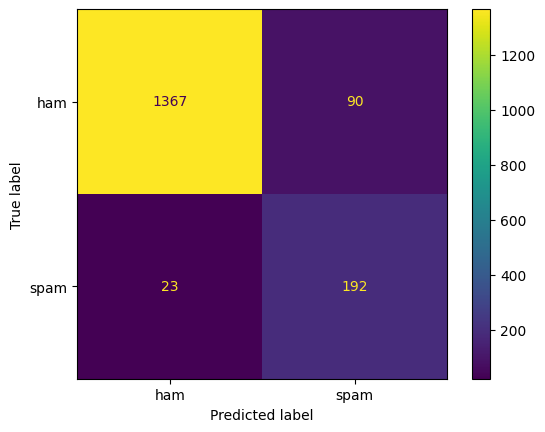

In [27]:
confusion_matrix_bayes = metrics.confusion_matrix(y_test, y_pred_bayes)
cm_display_bayes = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bayes, display_labels = ["ham", "spam"])

cm_display_bayes.plot()
plt.show()

### Precision, Recall and F-Score/F-measure for the Naive Bayes

In [29]:
print(metrics.classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1457
           1       0.68      0.89      0.77       215

    accuracy                           0.93      1672
   macro avg       0.83      0.92      0.87      1672
weighted avg       0.94      0.93      0.94      1672



### ROC Curve of the Naive Bayes

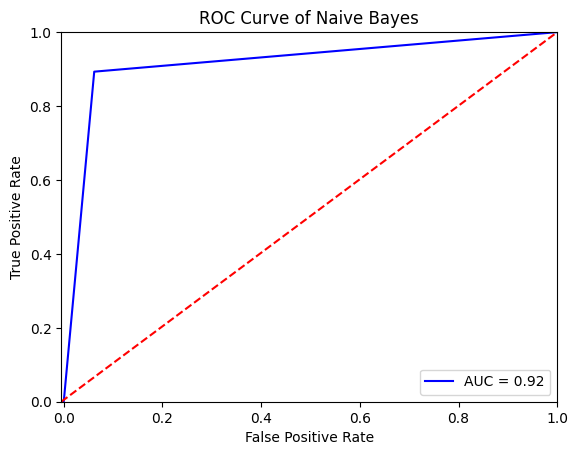

In [30]:
y_scores_bayes = nb.predict_proba(X_test)
fpr_bayes, tpr_bayes, threshold_bayes = roc_curve(y_test, y_scores_bayes[:, 1])

roc_auc_bayes = auc(fpr_bayes, tpr_bayes)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bayes, tpr_bayes, 'b', label = 'AUC = %0.2f' % roc_auc_bayes)
plt.legend(loc = 'lower right')
plt.plot([-0.005, 1], [0, 1],'r--')
plt.xlim([-0.005, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

# Comparisons

## Confusion Matrices

A confusion matrix is a technique for summarizing the performance of a classification algorithm.

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

Classification accuracy is a great place to start, but often encounters problems in practice.

The main problem with classification accuracy is that it hides the detail you need to better understand the performance of your classification model. There are two examples where you are most likely to encounter this problem:

When your data has more than 2 classes. With 3 or more classes you may get a classification accuracy of 80%, but you don’t know if that is because all classes are being predicted equally well or whether one or two classes are being neglected by the model.
When your data does not have an even number of classes. You may achieve accuracy of 90% or more, but this is not a good score if 90 records for every 100 belong to one class and you can achieve this score by always predicting the most common class value.
Classification accuracy can hide the detail you need to diagnose the performance of your model. But thankfully we can tease apart this detail by using a confusion matrix.

--------------------------------- KNN ---------------------------------


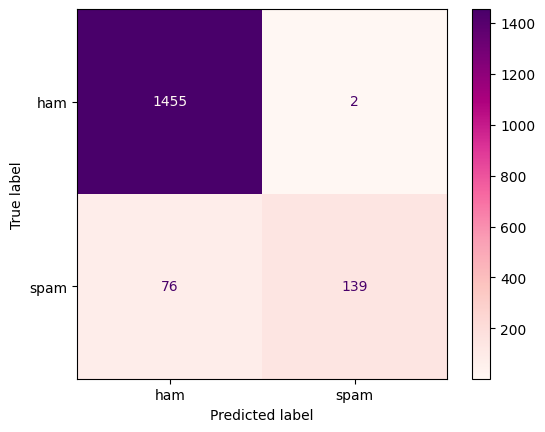


--------------------------------- SVM ---------------------------------


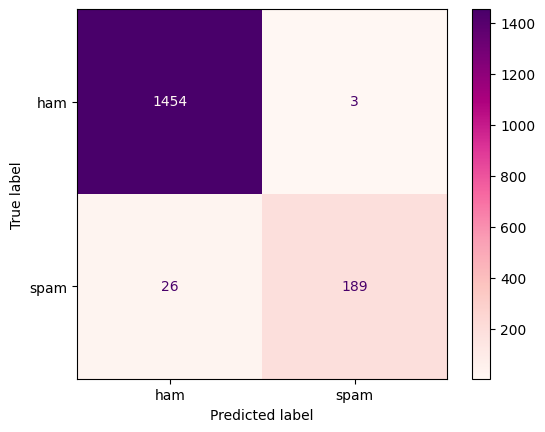


----------------------------- Naïve Bayes -----------------------------


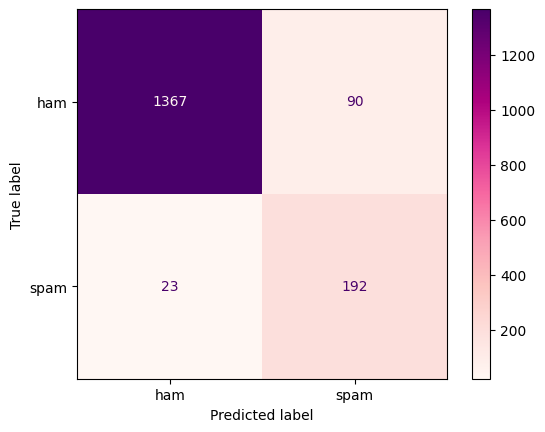

In [43]:
print("--------------------------------- KNN ---------------------------------")
confusion_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display_knn = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_knn, display_labels = ["ham", "spam"])

cm_display_knn.plot(cmap='RdPu')
plt.show()


print("\n--------------------------------- SVM ---------------------------------")
confusion_matrix_svm = metrics.confusion_matrix(y_test, y_pred_svm)
cm_display_svm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svm, display_labels = ["ham", "spam"])

cm_display_svm.plot(cmap='RdPu')
plt.show()


print("\n----------------------------- Naïve Bayes -----------------------------")
confusion_matrix_bayes = metrics.confusion_matrix(y_test, y_pred_bayes)
cm_display_bayes = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bayes, display_labels = ["ham", "spam"])

cm_display_bayes.plot(cmap='RdPu')
plt.show()



Looking at the confusion matrices here,
Although we observe that False Negative (FN) number is at least in naive bayes classifier, we see that True Negative (TN) number is best in knn and svm classifiers. Since the importance of the TN and FN numbers varies with each model, we make the following comment here:

If the user receives a non-spam mail and it is marked as spam (TN), it becomes a problem for us because an important mail can be overlooked by the user.
However, in the opposite case (mail spam and estimated as raw (FN)), a high number is not as bad as a high TN number.

In line with what has been said, we see that SVM gives the best results, and Naive Bayes gives the worst results, by looking only at the confusion matrixes.

## Precision, Recall and F-Score/F-measure

Often, we think that precision and recall both indicate accuracy of the model. While that is somewhat true, there is a deeper, distinct meaning of each of these terms. Precision means the percentage of your results which are relevant. On the other hand, recall refers to the percentage of total relevant results correctly classified by your algorithm.

Precision is the number of true positives divided by the number of true positives plus the number of false positives. False positives are cases the model incorrectly labels as positive that are actually negative, or in our example, individuals the model classifies as terrorists that are not. While recall expresses the ability to find all relevant instances of a class in a data set, precision expresses the proportion of the data points our model says existed in the relevant class that were indeed relevant.

**Recall**

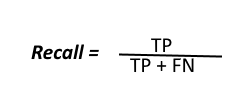

From all the positive classes, how many we predicted correctly.

Recall should be high as possible.

**Precision**

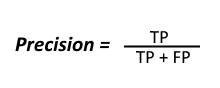

The above equation can be explained by saying, from all the classes we have predicted as positive, how many are actually positive.

Precision should be high as possible.



**Accuracy**

From all the classes (positive and negative), how many of them we have predicted correctly.

Accuracy should be high as possible.

**F-Score/Measure**

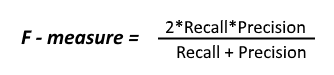

It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use F-Score. F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

In [49]:
print("----------------------- KNN ----------------------------")
print(metrics.classification_report(y_test, y_pred_knn))
print("----------------------- SVM ----------------------------")
print(metrics.classification_report(y_test, y_pred_svm))
print("------------------- Naïve Bayes ------------------------")
print(metrics.classification_report(y_test, y_pred_bayes))

----------------------- KNN ----------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1457
           1       0.99      0.65      0.78       215

    accuracy                           0.95      1672
   macro avg       0.97      0.82      0.88      1672
weighted avg       0.95      0.95      0.95      1672

----------------------- SVM ----------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1457
           1       0.98      0.88      0.93       215

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

------------------- Naïve Bayes ------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1457
           1       0.68      0.89      0.77       215

    accurac

In line with the explanations above, we see that Naive Bayes gives the worst precision value.

On the other hand, when we look at the SVM side, we see that it gives high results when we look at both precision, recall and f1-score.

KNN has an intermediate value as in the confusion matrix.

## ROC Curve Comparisons

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.


The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.


An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

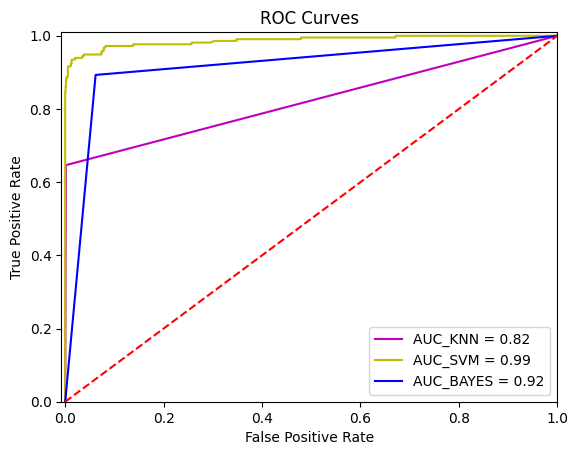

In [50]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn, tpr_knn, 'm', label = 'AUC_KNN = %0.2f' % roc_auc_knn)
plt.plot(fpr_svm, tpr_svm, 'y', label = 'AUC_SVM = %0.2f' % roc_auc_svm)
plt.plot(fpr_bayes, tpr_bayes, 'b', label = 'AUC_BAYES = %0.2f' % roc_auc_bayes)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.008, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curves')
plt.show()

Obviously, without the need for comment
SVM seems to give an almost perfect AUC here, by a wide margin.
On the other hand, since we give the k value 1 for KNN, we come across a somewhat bad graph. Although not here, as a result of our tests, we saw that the graph was better when we increased the k value. However, it has never yielded as good a result as SVM.

### Accuracies and Computation Times

In [20]:
print("KNN Accuracy", metrics.accuracy_score(y_test, y_pred_knn))
print("SVM Accuracy", metrics.accuracy_score(y_test, y_pred_svm))
print("Naive Bayes Accuracy", metrics.accuracy_score(y_test, y_pred_bayes))

KNN Accuracy 0.9533492822966507
SVM Accuracy 0.9826555023923444
Naive Bayes Accuracy 0.9324162679425837


In [21]:
print("KNN Computation Time", end_knn)
print("SVM Computation Time", end_svm)
print("Naive Bayes Computation Time", end_bayes)

KNN Computation Time 5.054893970489502
SVM Computation Time 1166.0742614269257
Naive Bayes Computation Time 5.473942756652832


# Conclusion

In line with the results explained above, we see that the Support Vector Machine (SVM) classifier gives the best results in terms of numerical values, namely accuracy, recall, f-score, FN and TN numbers, or AUC values. Considering that they show close values with KNN at some points, we can say that the KNN classifer gives good results for this dataset. 

Precision= spams correctly classified / (spams correctly classified + emails incorrectly labeled as spam)

Recall = spams correctly identified / (spams correctly identified + spams incorrectly identified as ham)

F1 score is the harmonic mean of precision and recall and is a better measure than accuracy.

About the Naive Bayes: 
We have seen a bit of the problems this classifer causes when working with big data as mentioned in the lesson.



However, after the part up to this point, we run into a problem:
Computation Times

We see huge differences in this regard.
Currently, we will not talk about Naive Bayes in this section, since we see that the performance values ​​are worse than the other two algorithms. Instead, we will compare the KNN and SVM classifiers, which have similar performance values, but have a huge difference in computation time.

The biggest factor that causes this situation is that we set the probability argument that we use for SVM as true.
When we did various researches on the Internet, we saw that the biggest factor in this long calculation process was due to this argument. However, we cannot use the predict_proba method in the direction of making this argument false, and we cannot draw a ROC curve in this direction.

In line with what has been said, our view is as follows:
Although the performance values ​​of SVM are better than KNN,
we believe that the KNN classifier is better (provided using a higher k value) because of such a long computational difference.

But of course, at the end of the day, this choice changes according to our purpose. If the calculation times are not too much trouble for you, the model you will choose for this dataset should definitely be SVM.
However, keep in mind that the complexity of SVM is O(n^2), so this computation time can be enormous when working with larger datasets.

On the other hand, if you have a larger dataset as we mentioned above and computation times are important to you, it would be better for you to wander around KNN for this dataset.